## QA-ALBERT model:


In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import time
from functools import partial
from transformers import AutoConfig, AutoTokenizer,AutoModel
import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader


# Dataset

In [ ]:
!git clone https://github.com/AUT-NLP/PQuAD.git
!pip install transformers  sentencepiece

fatal: destination path 'PQuAD' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.0 MB/s eta 0:00:00


In [ ]:
with open('PQuAD/Dataset/Train.json','r') as f:
    train_data = json.load(f)
train_data = train_data['data']

with open('PQuAD/Dataset/Validation.json','r') as f:
    validation_data = json.load(f)
validation_data = validation_data['data']

with open('PQuAD/Dataset/Test.json','r') as f:
    test_data = json.load(f)
test_data = test_data['data']


In [ ]:
print('number of titles of train data : ',len(train_data))
print('number of titles of validation data : ',len(validation_data))
print('number of titles of test data : ',len(test_data))

number of titles of train data :  891
number of titles of validation data :  120
number of titles of test data :  114


In [ ]:
print('number of paragraphs of train data : ',sum([len(train_data[i]['paragraphs']) for i in range(len(train_data))]))
print('number of paragraphs of validation data : ',sum([len(validation_data[i]['paragraphs']) for i in range(len(validation_data))]))
print('number of paragraphs of test data : ',sum([len(test_data[i]['paragraphs']) for i in range(len(test_data))]))

number of paragraphs of train data :  8979
number of paragraphs of validation data :  1103
number of paragraphs of test data :  1059


In [ ]:
print('number of questions of train data : ', sum([len(train_data[i]['paragraphs'][j]['qas'])
                                                   for i in range(len(train_data))
                                                   for j in range(len(train_data[i]['paragraphs']))]))

print('number of questions of validation data : ', sum([len(validation_data[i]['paragraphs'][j]['qas'])
                                                   for i in range(len(validation_data))
                                                   for j in range(len(validation_data[i]['paragraphs']))]))

print('number of questions of test data : ', sum([len(test_data[i]['paragraphs'][j]['qas'])
                                                   for i in range(len(test_data))
                                                   for j in range(len(test_data[i]['paragraphs']))]))

number of questions of train data :  63994
number of questions of validation data :  7976
number of questions of test data :  8002


In [ ]:
device = torch.device("cuda")
dtype = torch.float

# preprocessing functions

In [ ]:
def get_word_located_answer(context_tokens, answer_tokens):
    for indx in range(len(context_tokens)-len(answer_tokens)+1):
        if answer_tokens == context_tokens[indx:indx+len(answer_tokens)]:
            return indx, len(answer_tokens)
    return None, None

def text_preprocessing(data, tokenizer):
    question_context = []
    labels = []
    unused_counte = 0
    for topic in data[:]:
        for paragraphs in topic['paragraphs']:
            context = paragraphs['context']
            context_tokens = tokenizer.tokenize(context)
            for qas in paragraphs['qas']:
                if not qas['is_impossible']:
                    question = qas['question']
                    question_tokens = tokenizer.tokenize(question)
                    tokenized = tokenizer(
                        question, context, padding='max_length', max_length=512, return_tensors="pt")
                    for answer in qas['answers']:
                        answer_text = answer['text']
                        answer_start = answer['answer_start']
                        if context[answer_start:answer_start+len(answer_text)] != answer_text:
                            continue
                        indx, length = get_word_located_answer(
                            context_tokens, tokenizer.tokenize(answer_text))
                        if indx is None:
                            unused_counte += 1
                            continue
                        question_context.append(tokenized['input_ids'])
                        label = np.zeros((tokenized['input_ids'].shape[1], 2))
                        label[indx+len(question_tokens)+2, 0] = 1.0
                        label[indx+length+len(question_tokens)+1, 1] = 1.0
                        labels.append(label)
    return torch.stack(question_context).squeeze(), torch.tensor([np.asarray(labels)]).squeeze().type(dtype), unused_counte

class CustomTextDataset(Dataset):
    def __init__(self, question_context, labels,pretrained_model):
        self.question_context = question_context
        self.labels = labels
        self.pretrained_model = pretrained_model
        self.pretrained_model.to(device)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, indx):
        self.pretrained_model.eval()
        # return  self.pretrained_model(torch.unsqueeze(self.question_context[indx].to(device),0))[0], self.labels[indx].to(device)
        return  {'question_context': self.question_context[indx],'labels': self.labels[indx]}
        self.pretrained_model(torch.unsqueeze(self.question_context[indx].to(device),0))[0], self.labels[indx].to(device)

def custom_collate(data,pretrained_model):
    inputs = torch.stack([d['question_context'] for d in data]).to(device)
    labels = torch.stack([d['labels'] for d in data]).to(device)
    return pretrained_model(inputs)[0], labels

# metrics

In [ ]:
def exactmatchh(y_true, y_pred):
    em_score = 0
    for i in range(len(y_true)):
        if y_pred[i, 0]==y_true[i,0] and y_pred[i,1]==y_true[i, 1]:
            em_score +=1
    return em_score/len(y_true)

def f1scores(y_true,y_pred):
    pred_list = []
    truth_list = []
    common_list = []
    for i in range(len(y_true)):
        true_index = set(range(y_true[i,0],y_true[i,1]+1))
        pred_index = set(range(y_pred[i,0],y_pred[i,1]+1))
        common = true_index.intersection(pred_index)
        common_list.append(len(true_index))
        truth_list.append(len(truth_list))
        pred_list.append(len(pred_index))

    if sum(pred_index)==0 or sum(true_index)==0:
        return 0
    prec = sum(common)/sum(pred_index)
    rec = sum(common)/sum(truth_list)

    if (prec+rec) ==0:
        return 0

    return 2*(prec*rec)/(prec+rec)

def metrics(y_true, y_pred):
    y_pred = y_pred.detach().to('cpu').numpy()
    y_true = y_true.detach().to('cpu').numpy()
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    em_score = exactmatchh(y_true, y_pred)
    f1_score = f1scores(y_true, y_pred)
    return {"em_score":em_score, "f1_score":f1_score }

def plot_results(loss,loss_val,metrics,title):
    plt.plot(range(len(loss)),loss,'b',label='train')
    plt.plot(range(len(loss)),loss_val,'r',label = 'validation')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title(title + ' loss')
    plt.legend()
    plt.savefig(title + ' loss')
    plt.show()
    f1_scores = []
    em_scores = []
    for metrics_epoch in metrics:
        em = []
        f1 = []
        for row in metrics_epoch:
            em.append(row['em_score'])
            f1.append(row['f1_score'])
        em_scores.append(np.mean(em))
        f1_scores.append(np.mean(f1))

    plt.plot(range(len(f1_scores)),f1_scores)
    plt.xlabel('epoch')
    plt.ylabel('f1 scores')
    plt.title(title + ' f1_scores')
    plt.savefig(title + ' f1_scores')
    plt.show()
    plt.plot(range(len(em_scores)),em_scores)
    plt.xlabel('epoch')
    plt.ylabel('em scores')
    plt.title(title + ' em_scores')
    plt.savefig(title + ' em_scores')
    plt.show()


# QA model

In [ ]:
class QAModel(nn.Module):
    def __init__(self, embedding_hidden_size, num_labels=2):
        super(QAModel, self).__init__()
        self.num_labels = num_labels
        self.fc = nn.Linear(embedding_hidden_size, num_labels)
        self.act_func = nn.Softmax(dim=0)
        self.float()
    def forward(self, x):
        logits = self.fc(x)
        return self.act_func(logits)

# 2 ALBERT Model

In [ ]:
model_name = "m3hrdadfi/albert-fa-base-v2"
albert_config = AutoConfig.from_pretrained(model_name)
albert_tokenizer = AutoTokenizer.from_pretrained(model_name)
albert_model = AutoModel.from_pretrained(model_name).float()

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 2.1 preprocessing

In [ ]:
question_context, labels, unused_counte = text_preprocessing( train_data, albert_tokenizer)
train_DS = CustomTextDataset(question_context, labels,albert_model)
print("unused train answers : ", unused_counte)
print("number of train QA pairs : ", len(question_context))

<ipython-input-10-ffaceec912c4>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.stack(question_context).squeeze(), torch.tensor([np.asarray(labels)]).squeeze().type(dtype), unused_counte


unused train answers :  2311
number of train QA pairs :  45961


In [ ]:
question_context_val, labels_val, unused_counte = text_preprocessing(validation_data, albert_tokenizer)
val_DS = CustomTextDataset(question_context_val, labels_val,albert_model)
print("unused validation answers : ", unused_counte)
print("number of validation QA pairs : ", len(question_context_val))

unused validation answers :  280
number of validation QA pairs :  8122


In [ ]:
question_context_test, labels_test, unused_counte=text_preprocessing(test_data, albert_tokenizer)
test_DS = CustomTextDataset(question_context_test,labels_test,albert_model)
print("unused test answers : ", unused_counte)
print("number of test QA pairs : ", len(question_context_test))

unused test answers :  334
number of test QA pairs :  8206


## 2.2 model

In [ ]:
for param in albert_model.parameters():
    param.requires_grad = False

In [ ]:
batch_size=64
n_epochs = 10
num_labels = 2
albert_collate = partial(custom_collate, pretrained_model=albert_model)

In [ ]:
checkpoint = False

In [ ]:
qa_model_albert = QAModel(albert_config.hidden_size, num_labels)
qa_model_albert.to(device)
optimizer = torch.optim.Adam(qa_model_albert.parameters(), lr=0.001)
train_loader = DataLoader(train_DS, shuffle=True, batch_size=batch_size,collate_fn=albert_collate)
val_loader = DataLoader(val_DS, shuffle=True, batch_size=batch_size,collate_fn=albert_collate)

loss_fct = nn.MSELoss()
losses = []
losses_val = []
metrics_list = []
start_epochs = 0
if checkpoint:
    checkpoint = torch.load('/content/drive/MyDrive/backup_qa_model_albert.pt')
    qa_model_albert.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epochs = checkpoint['epoch']+1
    losses = checkpoint['losses']
    losses_val = checkpoint['losses_val']
    metrics_list = checkpoint['metrics_list']

for epoch in range(start_epochs,n_epochs):
    start_epoch = time.time()
    epoch_loss = []
    qa_model_albert.train()
    start_batch = time.time()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = qa_model_albert(X_batch)
        active_logits = logits.view(-1, num_labels)
        active_labels = y_batch.view(-1, num_labels)
        loss = loss_fct(active_logits, active_labels)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.detach().to('cpu'))
        print('batch time : ', time.time() - start_batch)
        start_batch = time.time()


    print(f'epoch {epoch}  ==> loss : {np.mean(epoch_loss)}', end=' ')
    losses.append(np.mean(epoch_loss))

    metric_list=[]
    epoch_loss = []
    qa_model_albert.eval()
    for X_batch, y_batch in val_loader:
        logits = qa_model_albert(X_batch)
        active_logits = logits.view(-1, num_labels)
        active_labels = y_batch.view(-1, num_labels)
        loss = loss_fct(active_logits, active_labels)
        metric_list.append(metrics(y_batch,logits.squeeze()))
        epoch_loss.append(loss.detach().to('cpu'))
    losses_val.append(np.mean(epoch_loss))
    metrics_list.append(metric_list)
    print(f'epoch {epoch}  ==> loss val : {np.mean(epoch_loss)}', end=' ')
    print('epoch time : ', time.time() - start_epoch)

Streaming output truncated to the last 5000 lines.
batch time :  2.210294008255005
batch time :  2.2092273235321045
batch time :  2.2028725147247314
batch time :  2.2096478939056396
batch time :  2.208089828491211
batch time :  2.2134947776794434
batch time :  2.203007936477661
batch time :  2.209333658218384
batch time :  2.2105917930603027
batch time :  2.205622673034668
batch time :  2.208345651626587
batch time :  2.212575912475586
batch time :  2.2032244205474854
batch time :  2.209082841873169
batch time :  2.220167636871338
batch time :  2.210310459136963
batch time :  2.209519863128662
batch time :  2.206815004348755
batch time :  2.207009792327881
batch time :  2.2088568210601807
batch time :  2.2032718658447266
batch time :  2.2068958282470703
batch time :  2.205228090286255
batch time :  2.207646608352661
batch time :  2.207897663116455
batch time :  2.203768730163574
batch time :  2.2063939571380615
batch time :  2.2064998149871826
batch time :  2.2037086486816406
batch tim

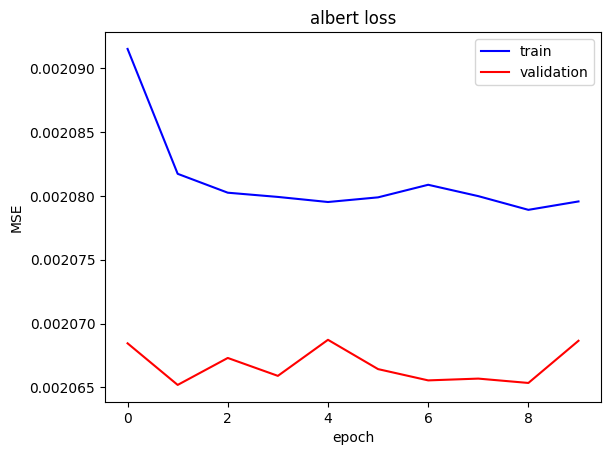

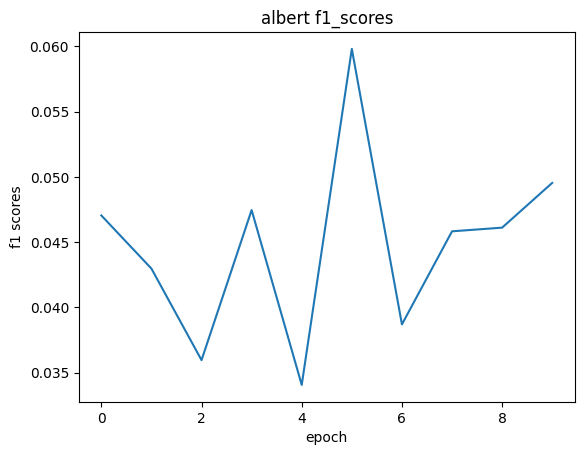

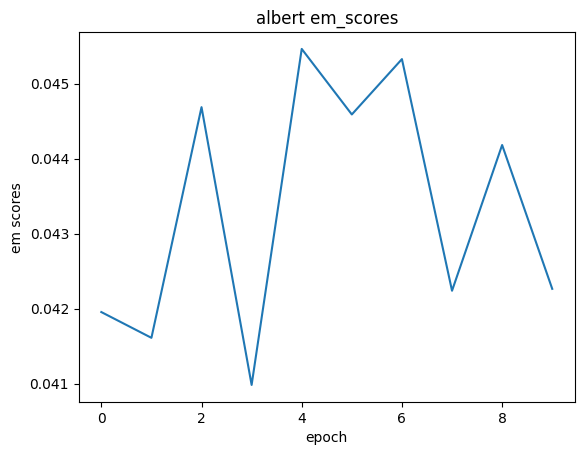

In [ ]:
plot_results(losses,losses_val,metrics_list,"albert")


## 2.3 model validation

In [ ]:
qa_model_albert.eval()
test_loader = DataLoader(test_DS, shuffle=True, batch_size=batch_size,collate_fn=albert_collate)
metric_list=[]
epoch_loss = []
for X_batch, y_batch in test_loader:
    logits = qa_model_albert(X_batch)
    active_logits = logits.view(-1, num_labels)
    active_labels = y_batch.view(-1, num_labels)
    loss = loss_fct(active_logits, active_labels)
    metric_list.append(metrics(y_batch,logits.squeeze()))
    epoch_loss.append(loss.detach().to('cpu'))

em = []
f1 = []
for row in metric_list:
    em.append(row['em_score'])
    f1.append(row['f1_score'])

print('loss test : ',np.mean(epoch_loss))
print('f1 score : ',np.mean(f1))
print('em score : ',np.mean(em))

loss test :  0.0021079835
f1 score :  0.031921662867006595
em score :  0.04379498892580288
